In [2]:
import sys
sys.path.append('../')
import JaxSSO.model as Model 
import JaxSSO.optimization as optimization
from JaxSSO import assemblemodel,solver
from JaxSSO.SSO_model import NodeParameter,SSO_model
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.patches import Polygon

# Set up the geometry, sectional properties, boundary conditions.

In [33]:
local_path = 'Data/Mannheim_Quad/' #path of the file
df = pd.read_csv(local_path + 'cnct.csv',header=None) #Connectivity matrix
n_ele = (df.to_numpy().shape[0]+1)//4 #number of elements
cnct = np.zeros((n_ele,4),dtype=int)
for i in range(n_ele):
    cnct[i,:] = df.to_numpy().ravel()[i*4:i*4+4]

df2 = pd.read_csv(local_path + 'crd_x.csv',header=None)
df3 = pd.read_csv(local_path + 'crd_y.csv',header=None)
df4 = pd.read_csv(local_path + 'crd_z.csv',header=None)
x_nodes = df2.to_numpy().ravel()
y_nodes = df3.to_numpy().ravel()
z_nodes = df4.to_numpy().ravel()
df5 = pd.read_csv(local_path + 'bc_node.csv',header=None)
bc_nodes =df5.to_numpy().ravel()
n_node = x_nodes.shape[0] #number of nodes
#Normalize the coordinates
xs = x_nodes-min(x_nodes)
ys = y_nodes-min(y_nodes)
x_span = max(xs) - min(xs)
y_span = max(ys)-min(ys)

zs = 0.1*np.array([1.16650095, 3.62250162, 0.63325483, 0.77655229, 1.31265331,
       1.68669962, 1.3108091 , 0.70937376, 0.75285485, 0.75147257,
       3.72966479, 3.33904017, 3.2852944 , 3.68587899, 3.94246337,
       3.28325979, 0.40413206, 0.50044157, 0.66623939, 1.16997263,
       1.38378168, 0.75926339, 0.93162776, 1.10626873, 0.62429206,
       0.48496525, 0.52765893, 0.37263336, 0.48602284, 0.37234998,
       0.62823902, 1.11117905, 1.51770931, 1.83650319, 1.33985457,
       1.35554889, 1.85021962, 2.24377223, 2.54619062, 2.07800999,
       2.11718138, 2.57550883, 2.93027954, 3.18962572, 2.76603404,
       2.84413549, 3.24312633, 3.53590915, 3.72819718, 3.35961348,
       3.49551447, 3.81602071, 4.02678719, 4.13139956, 3.82381225,
       4.03920535, 4.26486464, 4.37663276, 4.37626722, 4.13169936,
       4.4501666 , 4.56733296, 4.56619375, 4.44693168, 4.26387636,
       4.70967206, 4.70757647, 4.58283105, 4.3342407 , 4.20815888,
       4.80494237, 4.67590867, 4.42017962, 4.03530249, 3.95912661,
       4.72901498, 4.46859995, 4.07778906, 3.5529028 , 3.51744802,
       4.48074946, 4.08768435, 3.56068427, 2.89479812, 2.88902319,
       4.06484793, 3.54068514, 2.87879948, 2.07288733, 2.08401889,
       3.49174221, 2.84016068, 2.0462311 , 1.10224328, 1.11583318,
       2.77720325, 2.00296643, 1.08024217, 0.        , 0.        ,
       1.94152254, 1.04909232, 0.        , 1.00793791, 0.        ,
       0.95605401, 0.        , 0.89348999, 0.        , 0.82272567,
       0.        , 0.        , 0.        , 0.        , 0.81904075,
       0.        , 0.88612716, 0.        , 0.94339533, 0.        ,
       0.98836827, 0.        , 1.02138229, 0.        , 1.0441208 ,
       0.        , 1.05915698, 0.        , 1.0697462 , 0.        ,
       1.07933857, 0.        , 1.09038619, 0.        , 1.10285587,
       0.        , 1.11533725, 0.        , 1.12617231, 0.        ,
       1.13396352, 0.        , 1.13765824, 0.        , 1.13645844,
       0.        , 1.12969115, 0.        , 1.11668911, 0.        ,
       1.09668975, 0.        , 1.06874455, 0.        , 1.03162437,
       0.        , 0.98370166, 0.        , 0.92278552, 0.        ,
       0.8458956 , 0.        , 0.74908755, 0.        , 0.        ,
       0.        , 0.        , 0.31018502, 0.        , 0.27900664,
       0.        , 0.26406092, 0.        , 0.25720765, 0.        ,
       0.25454901, 0.        , 0.34355399, 0.33977273, 0.25720616,
       0.25454852, 0.        , 0.        , 0.26405546, 0.        ,
       0.27898629, 0.        , 0.31010909, 0.        , 0.        ,
       0.        , 0.        , 0.73926761, 0.        , 0.82625715,
       0.        , 0.88838222, 0.        , 0.92854509, 0.        ,
       0.94861997, 0.        , 0.94959274, 0.        , 0.93174535,
       0.        , 0.89478731, 0.        , 0.83800111, 0.        ,
       0.76058996, 0.        , 0.66272225, 0.        , 0.54849585,
       0.        , 0.43296673, 0.        , 0.35046502, 0.        ,
       0.30178512, 0.        , 0.27574564, 0.        , 0.26253666,
       0.        , 0.25603213, 0.        , 0.25288289, 0.        ,
       0.25137332, 0.        , 0.25065481, 0.        , 0.25031623,
       0.        , 0.25016191, 0.        , 0.25010216, 0.        ,
       0.33356257, 0.33347789, 0.2501623 , 0.25010229, 0.        ,
       0.        , 0.25031766, 0.        , 0.25066013, 0.        ,
       0.25139318, 0.        , 0.25295702, 0.        , 0.25630877,
       0.        , 0.2635691 , 0.        , 0.27959876, 0.        ,
       0.31616516, 0.        , 0.        , 0.        , 0.        ,
       0.85335037, 0.        , 0.9271843 , 0.        , 0.98567187,
       0.        , 1.03159921, 0.        , 1.06683462, 0.        ,
       1.09269767, 0.        , 1.11010191, 0.        , 1.11962301,
       0.        , 1.12153544, 0.        , 0.        , 2.08018801,
       2.0614203 , 2.86153714, 2.02718748, 2.81159037, 3.45338297,
       2.73758722, 3.35870024, 3.84691358, 3.23025049, 3.69500195,
       4.03788288, 3.49829417, 3.81782768, 4.02775699, 3.54071001,
       3.73095788, 3.82470701, 3.36399083, 3.4456919 , 3.44427856,
       2.98312452, 2.98132997, 2.90968577, 2.42156437, 2.36509893,
       2.2519674 , 1.71051151, 1.63205997, 1.51071209, 1.74967538,
       1.75133899, 2.42348652, 2.37125154, 1.71593466, 2.91532302,
       2.77625852, 2.26359529, 3.19732386, 2.94166939, 2.56212524,
       3.25006398, 2.85291565, 2.59049783, 3.06361642, 2.5063387 ,
       2.34081772, 2.6370167 , 1.9072237 , 1.81723731, 1.97637492,
       1.70304828, 1.56028714, 2.13430156, 1.87893689, 2.26643806,
       1.56455958, 1.86752561, 2.09746833, 1.37496982, 1.52996051,
       1.64273611, 1.17513652, 0.37199411, 0.41426316, 0.35170221,
       0.34204231, 0.33745945, 0.3352889 , 0.33426301, 0.33378153,
       0.37511394, 0.42243341, 0.35336274, 1.54504268, 1.69487817,
       2.33128772, 1.81373007, 2.50228919, 3.05995243, 2.63751988,
       3.23120388, 3.69629176, 3.36438479, 3.85257665, 4.21297763,
       3.96998575, 4.34329526, 4.58882451, 4.43472649, 4.68549745,
       4.80828762, 4.7434845 , 4.86637193, 4.86133005, 4.88571889,
       4.87832424, 4.74355458, 4.85602679, 4.71946298, 4.45649229,
       4.65511161, 4.39424211, 4.00786328, 4.29083459, 3.91395419,
       3.4115931 , 3.77885914, 3.29680607, 2.68742611, 3.14267926,
       2.56750593, 1.85993863, 2.41331304, 1.75612149, 2.21988508,
       1.6285136 , 1.98100542, 1.47789117, 2.6900416 , 2.37287915,
       1.97566399, 2.67813891, 2.20451392, 1.6154059 , 1.4718966 ,
       2.38218022, 1.73241923, 2.51428766, 1.82202881, 2.60613857,
       1.8863734 , 2.663854  , 1.92927728, 2.6954535 , 1.95609425,
       2.71222798, 1.97382258, 2.72970938, 1.99055522, 2.76409325,
       2.01268367, 2.8082731 , 2.03903337, 2.85285754, 2.06565416,
       2.89103718, 2.0887218 , 2.91853121, 2.10535688, 2.93267785,
       2.11354433, 2.93165093, 2.11181769, 2.91391715, 2.09895038,
       2.87787065, 2.07370887, 2.82157199, 2.03465868, 2.74253519,
       1.97999742, 1.9073846 , 3.46455678, 3.53561793, 4.05284764,
       3.58052997, 4.10439374, 4.49059894, 4.12693174, 4.51312437,
       4.76480301, 4.50349713, 4.75021762, 4.86670971, 4.69919397,
       4.80820889, 4.79294354, 4.70732165, 4.68576022, 4.54713114,
       4.52897789, 4.39015148, 4.14134424, 4.17648598, 3.93886508,
       3.59666539, 3.67429806, 3.3595914 , 2.94307299, 3.05766251,
       3.33621146, 2.91083341, 3.53538519, 3.08013637, 3.66266864,
       3.19337255, 3.72465555, 3.25787997, 3.72862452, 3.28297111,
       4.08278241, 4.05432575, 4.35488708, 4.29676603, 4.1333173 ,
       4.47786733, 4.27938581, 3.95185894, 3.84798732, 3.47979906,
       3.41044158, 4.03359689, 3.53737151, 4.09065742, 3.57838626,
       4.1220178 , 3.60031824, 3.60152439, 4.46196205, 4.38783302,
       4.60972066, 4.55893015, 4.31440305, 4.0305946 , 3.89585762])
xs = xs
ys = ys

xs_const = xs
ys_const = ys

In [34]:
#Properties, design nodes, load;
t = 0.1
E = 1e10
nu = 0.3 
design_nodes = []
non_design_nodes = []
for i in range(n_node):
    if i in bc_nodes:
      non_design_nodes.append(i)
      
    else:
      design_nodes.append(i)
      zs[i] = np.random.uniform(0.5,0.51)#random_z
design_nodes = np.asarray(design_nodes)
load = 5000



Disjoin a quad into 4-edges

In [35]:
raw_cnct_bar = []
raw_cnct = df.to_numpy().ravel()
for i in range(n_ele):
  raw_cnct_bar.append([raw_cnct[i*4],raw_cnct[i*4+1]])
  raw_cnct_bar.append([raw_cnct[i*4+1],raw_cnct[i*4+2]])
  raw_cnct_bar.append([raw_cnct[i*4+2],raw_cnct[i*4+3]])
  raw_cnct_bar.append([raw_cnct[i*4+3],raw_cnct[i*4]])

raw_cnct_bar = np.asarray(raw_cnct_bar) # with duplication

cnct_bar = []
for i in range(n_node):
  temp_list = []
  rows_i = np.argwhere(raw_cnct_bar==i)[:,0]
  cols_i = np.argwhere(raw_cnct_bar==i)[:,1]
  for j in range(rows_i.shape[0]):
    if cols_i[j] == 0:
      if raw_cnct_bar[rows_i[j],1] not in temp_list:
        temp_list.append(i)
        temp_list.append(raw_cnct_bar[rows_i[j],1])
    else:
      if raw_cnct_bar[rows_i[j],0] not in temp_list:
        temp_list.append(i)
        temp_list.append(raw_cnct_bar[rows_i[j],0])
  raw_cnct_bar = np.delete(raw_cnct_bar,rows_i,0)
  cnct_bar.extend(temp_list)
cnct_bar = np.asarray(cnct_bar,dtype=int)
cnct_network = cnct_bar.reshape(cnct_bar.shape[0]//2,2)

n_ele_bar = cnct_network.shape[0]
x_ele = np.zeros((n_ele_bar,2)) #x of the elements
y_ele = np.zeros((n_ele_bar,2))
z_ele = np.zeros((n_ele_bar,2))

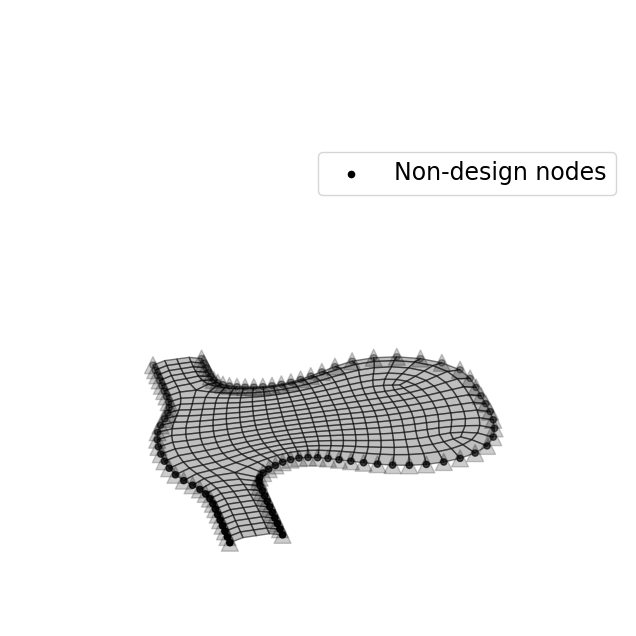

In [36]:
%matplotlib inline


for i in range(n_ele_bar):
  x_ele[i,:] = [xs[cnct_network[i,0]],xs[cnct_network[i,1]]]
  y_ele[i,:] = [ys[cnct_network[i,0]],ys[cnct_network[i,1]]]
  z_ele[i,:] = [zs[cnct_network[i,0]],zs[cnct_network[i,1]]]

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,40)
ax.set_xlabel('X (m)',fontsize=15)
ax.set_ylabel('Y (m)',fontsize=15)
ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
#  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')
all_corners = []

for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    all_corners.append([[xs[inode],ys[inode],zs[inode]],
                        [xs[jnode],ys[jnode],zs[jnode]],
                        [xs[mnode],ys[mnode],zs[mnode]],
                        [xs[nnode],ys[nnode],zs[nnode]],
                       ])

tdco = Poly3DCollection(all_corners)
tdco.set_alpha(0.5)
tdco.set_facecolor('grey')
tdco.set_edgecolor('black')
ax.add_collection3d(tdco)

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')
ax.view_init(30, -105)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.axis('off')
plt.show()


# Define the hat filter

In [37]:
def Linear_filter(dist,R):
    '''
    A linear filter with radius R, will be normalized later to satisfy unit-intergral condition.
    '''
    return np.where(dist>R,0,(1/R)*(R-dist))


Create filter mapping matrix $B_{ij}$

$z_i = B_{ij}p_j$

$\frac{df}{dp_j} = B_{ij}\frac{df}{dz_i}$

In [38]:
#Matrix storing XY-projected distance  
dx_ij = xs[:,None]-xs[None,:]
dy_ij = ys[:,None]-ys[None,:]
D_ij = (dx_ij**2 + dy_ij**2)**0.5

#Create the filter mapping matrix
B_ij_ini = Linear_filter(D_ij,10)
B_ij_sum = np.sum(B_ij_ini,axis=1)
B_ij_sum = B_ij_sum.repeat(xs.shape[0]).reshape(xs.shape[0],xs.shape[0])
B_ij = B_ij_ini/B_ij_sum

In [26]:
zs_filtered = zs.copy()
zs_filtered[design_nodes] =(B_ij@zs_filtered)[design_nodes]

# Create FE model and SSO_model

In [27]:
#Create model
model = Model.Model() #model for sensitivity analysis

#Adding nodes and boundary conditions
for i in range(n_node):
    model.add_node(i,xs[i],ys[i],zs_filtered[i])
    if i not in design_nodes:
        model.add_support(i,[1,1,1,1,1,1])
    else:
        model.add_nodal_load(i,nodal_load=[0.0,0.0,-load,0.0,0.0,0.0])
        zs[i] = np.random.uniform(0.5,0.51)#random_z

#Adding elements
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    model.add_quad(i,inode, jnode, mnode, nnode, 
                t, E, nu)

model.model_ready()

# Start the SSO model
sso_model = SSO_model(model) # initial sso model
for node in design_nodes:
    nodeparameter = NodeParameter(node,2) # nodeparamter object
    sso_model.add_nodeparameter(nodeparameter)

#Initial the parameters
sso_model.initialize_parameters_values()
sso_model.set_objective(objective='strain energy',func=None,func_args=None)

# Define objective function, and conduct optimization

In [28]:
C_hist = []
def objective_filter(x,sso_model=sso_model):
    p = zs.copy()
    p[design_nodes]=x
    z = (B_ij@p)[design_nodes]
    sso_model.update_nodeparameter(z) # Update the model
    C,sens = sso_model.value_grad_params(which_solver='sparse',enforce_scipy_sparse = True)
    C_hist.append(C)
    return C,np.asarray((sens@B_ij[design_nodes])[design_nodes],dtype=float)#sens_params

In [29]:
n_x = design_nodes.shape[0] #number of parameters
x_ini = sso_model.nodeparameters_values #initial parameters 
opt = optimization.Optimization(n_x,method='GD')
opt.set_objective(objective_filter) #objective function
opt.set_maxiter(200) #max iteration
opt.set_step_size(1e-1) #step size
opt.set_GD_normalized(True) #normalized
x_opt = opt.optimize(x_ini,log=True)

Step 0, objective = 297217.1638739023
Step 1, objective = 145066.7175908171
Step 2, objective = 83366.64132961925
Step 3, objective = 58871.14699859502
Step 4, objective = 46799.503992955666
Step 5, objective = 39817.777133818665
Step 6, objective = 35007.93671629121
Step 7, objective = 32636.049415892674
Step 8, objective = 29540.57435315148
Step 9, objective = 27729.271211630832
Step 10, objective = 25591.263804368427
Step 11, objective = 24128.92822799852
Step 12, objective = 22578.705678903567
Step 13, objective = 21369.599193847273
Step 14, objective = 20166.100979818955
Step 15, objective = 19155.516482147694
Step 16, objective = 18181.7868122217
Step 17, objective = 17323.799882449377
Step 18, objective = 16503.03633092428
Step 19, objective = 15766.246095279106
Step 20, objective = 15063.025037919633
Step 21, objective = 14425.120827038902
Step 22, objective = 13815.867691720436
Step 23, objective = 13259.893714673906
Step 24, objective = 12727.669382182577
Step 25, objective =

# Plot the results

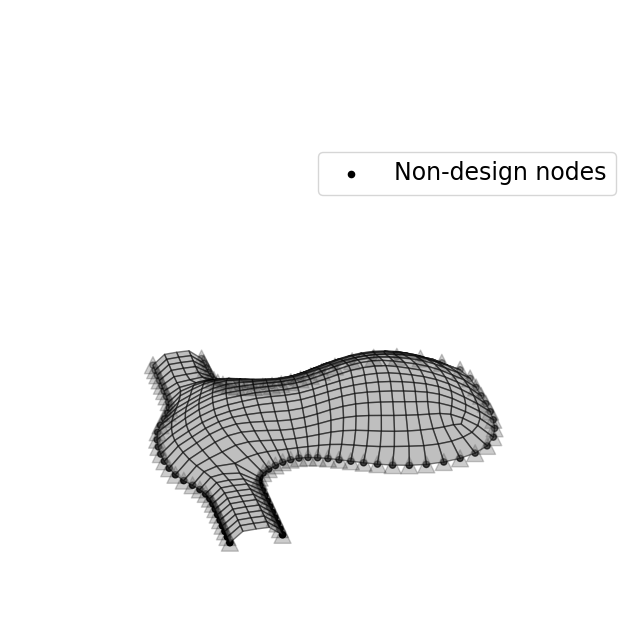

In [31]:
%matplotlib inline

zs[design_nodes] = x_opt
zs_filtered = zs.copy()
zs_filtered[design_nodes] =(B_ij@zs)[design_nodes]

for i in range(n_ele_bar):
  x_ele[i,:] = [xs[cnct_network[i,0]],xs[cnct_network[i,1]]]
  y_ele[i,:] = [ys[cnct_network[i,0]],ys[cnct_network[i,1]]]
  z_ele[i,:] = [zs_filtered[cnct_network[i,0]],zs_filtered[cnct_network[i,1]]]

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,40)
ax.set_xlabel('X (m)',fontsize=15)
ax.set_ylabel('Y (m)',fontsize=15)
ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
  #ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='black')

all_corners = []


for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    all_corners.append([[xs[inode],ys[inode],zs_filtered[inode]],
                        [xs[jnode],ys[jnode],zs_filtered[jnode]],
                        [xs[mnode],ys[mnode],zs_filtered[mnode]],
                        [xs[nnode],ys[nnode],zs_filtered[nnode]],
                       ])

tdco = Poly3DCollection(all_corners)
tdco.set_alpha(0.5)
tdco.set_facecolor('grey')
tdco.set_edgecolor('black')
ax.add_collection3d(tdco)

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')
ax.view_init(30, -105)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.axis('off')
plt.show()

Text(0, 0.5, 'Total strain energy (KN$\\cdot$m)')

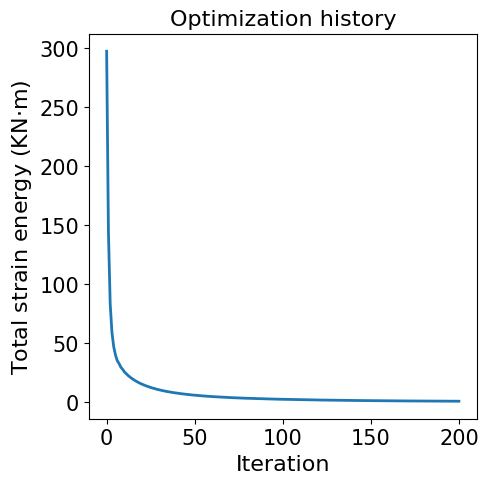

In [32]:


fig, ax = plt.subplots(figsize=(5,5))

plt.plot(np.linspace(0,200,200),np.array(C_hist)/1000,linewidth=2)
plt.xticks([0,50,100,150,200],fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Iteration',fontsize=16)
plt.title('Optimization history',fontsize=16)
plt.ylabel(r'Total strain energy (KN$\cdot$m)',fontsize=16)